<a href="https://colab.research.google.com/github/densemuch/I4_ai_eng/blob/main/I4_fairness.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load libraries

In [ ]:
# !pip install 'aif360[all]'

In [ ]:
import sys
sys.path.insert(1, "../")  

import numpy as np
np.random.seed(0)

from aif360.datasets import GermanDataset, StandardDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from aif360.algorithms.postprocessing import EqOddsPostprocessing, RejectOptionClassification, CalibratedEqOddsPostprocessing

from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, fbeta_score
from sklearn.metrics import roc_curve, roc_auc_score, precision_score, f1_score


from IPython.display import Markdown, display
import matplotlib.pyplot as plt

# Task 1

Using GermanDataset class to load the data, followed by splitting the data into 70, 30 split for training and testing respectively

## Data Loading and Pre-Processing

In [ ]:
dataset_orig = GermanDataset(
    protected_attribute_names=[], 
    categorical_features=['status', 'credit_history', 'purpose', 'savings', 'employment', 
                          'other_debtors', 'property', 'installment_plans', 'housing', 'skill_level',
                          'telephone', 'foreign_worker', 'sex'])
dataset_orig_train, dataset_orig_test = dataset_orig.split([0.7], shuffle=True, seed=42)

Converting above GermanDataset class objects to pandas dataframes

In [ ]:
data_train = dataset_orig_train.convert_to_dataframe()[0]
data_test = dataset_orig_test.convert_to_dataframe()[0]
flip_value = data_train['sex=female'].to_numpy()
data_train = data_train.drop('sex=female', 1)
data_test = data_test.drop('sex=female', 1)

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only


In [ ]:
data_train.head()

,month,credit_amount,investment_as_income_percentage,residence_since,age,number_of_credits,people_liable_for,status=A11,status=A12,status=A13,...,skill_level=A171,skill_level=A172,skill_level=A173,skill_level=A174,telephone=A191,telephone=A192,foreign_worker=A201,foreign_worker=A202,sex=male,credit
521,18.0,3190.0,2.0,2.0,24.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,2.0
737,18.0,4380.0,3.0,4.0,35.0,1.0,2.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0
740,24.0,2325.0,2.0,3.0,32.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0
660,12.0,1297.0,3.0,4.0,23.0,1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0
411,33.0,7253.0,3.0,2.0,35.0,2.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0


From above we can see that id credit=2.0 it means that the customer is **bad** and if credit =1.0 the customer is **good**. 

**It is worse to classify a customer as good when they are bad, than it is to classify a customer as bad when they are good**

Splitting above train and test datasets into features and labels

In [ ]:
X_train = data_train.drop('credit', 1).values
y_train = data_train['credit'].values

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only


In [ ]:
X_test = data_test.drop('credit', 1).values
y_test = data_test['credit'].values

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only


In [ ]:
print('train data', X_train.shape)
print('train label', y_train.shape)
print('test data', X_test.shape)
print('test label', y_test.shape)

train data (700, 58)
train label (700,)
test data (300, 58)
test label (300,)


## Build Model 

We will be using Gaussian Naive Bayes classifier for modeling the credit.

In [ ]:
GNB = GaussianNB()

# Fitting with train data
model = GNB.fit(X_train, y_train)

We now calculate the mean accuracy of the model

## Evaluate Model

In [ ]:
print(model.score(X_train, y_train))

0.7414285714285714


Using sklearn metrics we get the accuracy, confusion matrix and also the classification report for the test data

In [ ]:
y_pred = model.predict(X_test)

print('accuracy', accuracy_score(y_test,y_pred))
print("\n")
print('confusion_matrix', confusion_matrix(y_test, y_pred))
print("\n")
print(classification_report(y_test, y_pred))
print("\n")


accuracy 0.77


confusion_matrix [[165  43]
 [ 26  66]]


              precision    recall  f1-score   support

         1.0       0.86      0.79      0.83       208
         2.0       0.61      0.72      0.66        92

    accuracy                           0.77       300
   macro avg       0.73      0.76      0.74       300
weighted avg       0.78      0.77      0.77       300





From above we can see that the precision is more for when credit is good (1.0). This aligns with our objective that it is worse to classify a customer as good when they are bad 

Get predictions on train data too

In [ ]:
y_train_pred = model.predict(X_train)


### ROC curve and AUC

roc_auc score 0.8031981605351171


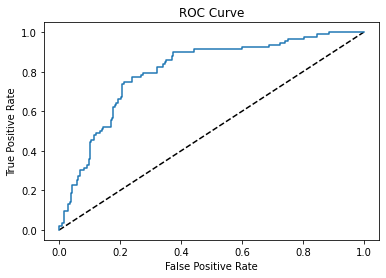

In [ ]:
#Predicting proba
y_pred_prob = model.predict_proba(X_test)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob, pos_label=2)
roc_auc = roc_auc_score(y_test, y_pred_prob)

print('roc_auc score', roc_auc)
# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

# Task 2

Create dataframe to store test data and model predictions

In [ ]:
data_test_pred = data_test.copy()
data_test_pred['credit'] = y_pred

In [ ]:
data_train_pred = data_train.copy()
data_train_pred['credit'] = y_train_pred

### Measuring of Fairness with Age as Protected Attribute

Create StandardDataset class object for test data with ground truth as well as model predictions

In [ ]:
standard_dataset_test = StandardDataset(data_test, protected_attribute_names=['age'],
                                        label_name='credit', favorable_classes=[1], privileged_classes=[lambda x: x >= 25])

In [ ]:
standard_dataset_test_pred = StandardDataset(data_test_pred, protected_attribute_names=['age'],
                                        label_name='credit', favorable_classes=[1], privileged_classes=[lambda x: x >= 25])

Set privileged groups for age

In [ ]:
privileged_groups = [{'age': 1}]
unprivileged_groups = [{'age': 0}]

In [ ]:
metric_classified_test = ClassificationMetric(standard_dataset_test, standard_dataset_test_pred, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)

#### Fairness Metric

In [ ]:
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_classified_test.mean_difference())


Difference in mean outcomes between unprivileged and privileged groups = -0.038690


**The negative value here indicates less favorable outcomes for the unprivileged groups**

#### Calculate individual fairness

In [ ]:
print('consistency', metric_classified_test.consistency()[0])

consistency 0.6686666666666663


#### Calculate group fairness by measuring disparate impact ratio


The calculation is the proportion of the unprivileged group that received the positive outcome divided by the proportion of the privileged group that received the positive outcome.

In [ ]:

print('disparate impact', metric_classified_test.disparate_impact())

disparate impact 0.9398148148148147


#### Calculate Separation

Binary Confusion Matrix for unprivileged class i.e, age under 25

In [ ]:
unprivileged_dict = metric_classified_test.binary_confusion_matrix(privileged=False)

Binary Confusion Matrix for privileged class i.e, age over 25

In [ ]:
privileged_dict = metric_classified_test.binary_confusion_matrix(privileged=True)

In [ ]:
fp_rate_priv = privileged_dict["FP"]/(privileged_dict["FP"]+privileged_dict["TN"])
fp_rate_unpriv = unprivileged_dict["FP"]/(unprivileged_dict["FP"]+unprivileged_dict["TN"])

In [ ]:
print("FP Rate for Priviliged Age class", fp_rate_priv)
print("FP Rate for Unpriviliged Age class", fp_rate_unpriv)

FP Rate for Priviliged Age class 0.25
FP Rate for Unpriviliged Age class 0.4


In [ ]:
fn_rate_priv = privileged_dict["FN"]/(privileged_dict["FP"]+privileged_dict["TN"])
fn_rate_unpriv = unprivileged_dict["FN"]/(unprivileged_dict["FP"]+unprivileged_dict["TN"])

In [ ]:
print("FN Rate for Priviliged Age class", fn_rate_priv)
print("FN Rate for Unpriviliged Age class", fn_rate_unpriv)

FN Rate for Priviliged Age class 0.5
FN Rate for Unpriviliged Age class 0.35


In [ ]:
print('accuracy', metric_classified_test.accuracy())


accuracy 0.77


**We observe that the False Negative Rate is more in Unprivileged (lower Age) class where as False Positive Rate is more in Privileged class**




### Measuring of Fairness with Sex as Protected Attribute

Create StandardDataset class object for test data with ground truth as well as model predictions

In [ ]:
standard_dataset_test_sex = StandardDataset(data_test, protected_attribute_names=['sex=male'],
                                        label_name='credit', favorable_classes=[1], privileged_classes=[[1.0]])

In [ ]:
standard_dataset_test_pred_sex = StandardDataset(data_test_pred, protected_attribute_names=['sex=male'],
                                        label_name='credit', favorable_classes=[1], privileged_classes=[[1.0]])

Set privileged groups for sex

In [ ]:
privileged_groups = [{'sex=male': 1}]
unprivileged_groups = [{'sex=male': 0}]

In [ ]:
metric_classified_test = ClassificationMetric(standard_dataset_test_sex, standard_dataset_test_pred_sex, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)

#### Fairness metric

In [ ]:
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_classified_test.mean_difference())

Difference in mean outcomes between unprivileged and privileged groups = -0.076727


**The negative value here indicates less favorable outcomes for the unprivileged groups**





#### Calculate individual fairness using consistency

In [ ]:
print('consistency', metric_classified_test.consistency()[0])

consistency 0.6719999999999995


In [ ]:
print('precision', metric_classified_test.precision())
print('recall', metric_classified_test.recall())

precision 0.8638743455497382
recall 0.7932692307692307


#### Calculate group fairness by measuring disparate impact ratio


The calculation is the proportion of the unprivileged group that received the positive outcome divided by the proportion of the privileged group that received the positive outcome.

In [ ]:
print('disparate impact', metric_classified_test.disparate_impact())

disparate impact 0.884319526627219


#### Calculate Separation

Binary Confusion Matrix for unprivileged class i.e, female

In [ ]:
unprivileged_dict = metric_classified_test.binary_confusion_matrix(privileged=False)

Binary Confusion Matrix for privileged class i.e, male

In [ ]:
privileged_dict = metric_classified_test.binary_confusion_matrix(privileged=True)

In [ ]:
fp_rate_priv = privileged_dict["FP"]/(privileged_dict["FP"]+privileged_dict["TN"])
fp_rate_unpriv = unprivileged_dict["FP"]/(unprivileged_dict["FP"]+unprivileged_dict["TN"])

In [ ]:
print("FP Rate for Priviliged sex class", fp_rate_priv)
print("FP Rate for Unpriviliged sex class", fp_rate_unpriv)

FP Rate for Priviliged sex class 0.2982456140350877
FP Rate for Unpriviliged sex class 0.2571428571428571


In [ ]:
fn_rate_priv = privileged_dict["FN"]/(privileged_dict["FP"]+privileged_dict["TN"])
fn_rate_unpriv = unprivileged_dict["FN"]/(unprivileged_dict["FP"]+unprivileged_dict["TN"])

In [ ]:
print("FN Rate for Priviliged sex class", fn_rate_priv)
print("FN Rate for Unpriviliged sex class", fn_rate_unpriv)

FN Rate for Priviliged sex class 0.45614035087719296
FN Rate for Unpriviliged sex class 0.4857142857142857


In [ ]:
print('accuracy', metric_classified_test.accuracy())


accuracy 0.77


**We observe that the False Negative Rate is more in Unprivileged (Female) class where as False Positive Rate is more in Privileged class**




# Task 3



### Improve Model Fairness on Protect Attribute - Sex

#### Improve Group Fairness and Separation

In [ ]:
standard_dataset_train_sex = StandardDataset(data_train, protected_attribute_names=['sex=male'],
                                        label_name='credit', favorable_classes=[1], privileged_classes=[[1.0]])

In [ ]:
standard_dataset_train_pred_sex = StandardDataset(data_train_pred, protected_attribute_names=['sex=male'],
                                        label_name='credit', favorable_classes=[1], privileged_classes=[[1.0]])

In [ ]:
privileged_groups = [{'sex=male': 1}]
unprivileged_groups = [{'sex=male': 0}]

In [ ]:
cost_constraint = 'fpr'

In [ ]:
cpp = CalibratedEqOddsPostprocessing(privileged_groups = privileged_groups,
                                     unprivileged_groups = unprivileged_groups,
                                     cost_constraint=cost_constraint,
                                     seed=12345679 )

In [ ]:
cpp_1 = cpp.fit(standard_dataset_train_sex, standard_dataset_train_pred_sex)

In [ ]:
cpp_test_pred = cpp_1.predict(standard_dataset_test_pred_sex, threshold=0.5)

In [ ]:
metric_classified_test = ClassificationMetric(standard_dataset_test_sex, cpp_test_pred, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)

#### Fairness Metric

In [ ]:
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_classified_test.mean_difference())


Difference in mean outcomes between unprivileged and privileged groups = 0.057889


#### Calculate group fairness by measuring disparate impact ratio


The calculation is the proportion of the unprivileged group that received the positive outcome divided by the proportion of the privileged group that received the positive outcome.

In [ ]:
print('disparate impact', metric_classified_test.disparate_impact())

disparate impact 1.0872781065088757


In [ ]:
print('accuracy', metric_classified_test.accuracy())

accuracy 0.7433333333333333


The disparate impact ratio is near 1, hence showing improvement.

#### Calculate Separation

In [ ]:
eq = EqOddsPostprocessing(privileged_groups = privileged_groups,
                                     unprivileged_groups = unprivileged_groups,
                                     seed=12345679)

In [ ]:
eq_1 = eq.fit(standard_dataset_train_sex, standard_dataset_train_pred_sex)

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [ ]:
eq_test_pred = eq_1.predict(standard_dataset_test_pred_sex)

In [ ]:
metric_classified_test = ClassificationMetric(standard_dataset_test_sex, eq_test_pred, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)

Binary Confusion Matrix for unprivileged class i.e, female

In [ ]:
unprivileged_dict = metric_classified_test.binary_confusion_matrix(privileged=False)

Binary Confusion Matrix for privileged class i.e, male

In [ ]:
privileged_dict = metric_classified_test.binary_confusion_matrix(privileged=True)

In [ ]:
fp_rate_priv = privileged_dict["FP"]/(privileged_dict["FP"]+privileged_dict["TN"])
fp_rate_unpriv = unprivileged_dict["FP"]/(unprivileged_dict["FP"]+unprivileged_dict["TN"])

In [ ]:
print("FP Rate for Priviliged sex class", fp_rate_priv)
print("FP Rate for Unpriviliged sex class", fp_rate_unpriv)

FP Rate for Priviliged sex class 0.2982456140350877
FP Rate for Unpriviliged sex class 0.2857142857142857


In [ ]:
fn_rate_priv = privileged_dict["FN"]/(privileged_dict["FP"]+privileged_dict["TN"])
fn_rate_unpriv = unprivileged_dict["FN"]/(unprivileged_dict["FP"]+unprivileged_dict["TN"])

In [ ]:
print("FN Rate for Priviliged sex class", fn_rate_priv)
print("FN Rate for Unpriviliged sex class", fn_rate_unpriv)

FN Rate for Priviliged sex class 0.5263157894736842
FN Rate for Unpriviliged sex class 0.37142857142857144


In [ ]:
print('accuracy', metric_classified_test.accuracy())

accuracy 0.7666666666666667


**We observe that the False Negative Rate is almost same for both Unprivileged (Female) class and Privileged class (Male)**




**We observe that the False Positive Rate is more for both Unprivileged (Female) class compared to Privileged class (Male)**

#### Improve Anti classification score - consistency

In [ ]:
drop_data_test = data_test.drop('sex=male', 1)
drop_data_test_pred = data_test_pred.drop('sex=male', 1)

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only


In [ ]:
standard_dataset_test_sex = StandardDataset(drop_data_test, protected_attribute_names=[], privileged_classes=[],
                                        label_name='credit', favorable_classes=[1])

In [ ]:
standard_dataset_test_pred_sex = StandardDataset(drop_data_test_pred, protected_attribute_names=[],
                                        label_name='credit', favorable_classes=[1], privileged_classes=[])

In [ ]:
metric_classified_test = ClassificationMetric(standard_dataset_test_sex, standard_dataset_test_pred_sex, 
                                             unprivileged_groups=[],
                                             privileged_groups=[])

In [ ]:
print('consistency', metric_classified_test.consistency()[0])

consistency 0.6719999999999995


In [ ]:
print('accuracy', metric_classified_test.accuracy())


accuracy 0.77
